In [1]:
################################################################################
########################          Yelp Reviews          ######################## 
########################   Classification : lightGBM    ######################## 
########################  Stars on Reviews: 1 & 2 vs 5  ########################
################################################################################

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM


In [4]:
# Clone lightGBM
! git clone --recursive https://github.com/Microsoft/LightGBM

fatal: destination path 'LightGBM' already exists and is not an empty directory.


In [5]:
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/LightGBM

! mkdir build

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/LightGBM
mkdir: cannot create directory ‘build’: File exists


In [6]:
# Compile
! cmake -DUSE_GPU=1 #avoid ..
! make -j$(nproc)

CMake Error: The current CMakeCache.txt directory /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/LightGBM/CMakeCache.txt is different than the directory /content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/LightGBM where CMakeCache.txt was created. This may result in binaries being created in the wrong place. If you are not sure, reedit the CMakeCache.txt
CMake Error: The source "/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/LightGBM/CMakeLists.txt" does not match the source "/content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/LightGBM/CMakeLists.txt" used to generate cache.  Re-run cmake with a different source directory.
-- OpenCL include directory: /usr/include
-- Boost version: 1.65.1
-- Found the following Boost libraries:
--   filesystem
--   system
-- Using _mm_prefetch
-- Using _mm_malloc
-- Configuring done
-- Generating done
-- Build files have been written to: /content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/LightGBM
[ -1%] Built target lig

In [7]:
! sudo apt-get -y install python-pip

! sudo -H pip install setuptools numpy pandas scikit-learn sklearn joblib optuna gensim==3.8.3 datetime plotly matplotlib==3.4.2 seaborn -U

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-pip is already the newest version (9.0.1-2.3~ubuntu1.18.04.5).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [8]:
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/LightGBM/python-package

! sudo python3 setup.py install --precompile --gpu

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/LightGBM/python-package
running install
/usr/local/lib/python3.7/dist-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,
running build
running build_py
running egg_info
writing lightgbm.egg-info/PKG-INFO
writing dependency_links to lightgbm.egg-info/dependency_links.txt
writing requirements to lightgbm.egg-info/requires.txt
writing top-level names to lightgbm.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
no previously-included directories found matching 'build'
writing manifest file 'lightgbm.egg-info/SOURCES.txt'
copying lightgbm/VERSION.txt -> build/lib/lightgbm
running install_lib
copying build/lib/lightgbm/VERSION.txt -> /usr/lib/python3.7/site-packages/lightgbm
INFO:LightGBM:Installing lib_lightgbm from: ['/content/drive/MyDrive/Yelp_Reviews/ML/Classificati

In [9]:
import os
import random
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
from timeit import default_timer as timer
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim import models
import multiprocessing
import pickle
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from lightgbm import LGBMClassifier
import optuna
from optuna import Trial
optuna.logging.set_verbosity(optuna.logging.WARNING) # use INFO to see progress
from optuna.integration import LightGBMPruningCallback
import joblib
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

my_dpi=96

In [10]:
print('CUDA and NVIDIA GPU Information')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

print('\n')
cores = multiprocessing.cpu_count()
print('Number of cores:', cores)

CUDA and NVIDIA GPU Information
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Fri Apr 15 16:36:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|            

In [11]:
# Set seed 
seed_value = 42
os.environ['YelpReviews_ML'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [12]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/

/content/drive/MyDrive/Yelp_Reviews/Data


In [13]:
# Read tokenized reviews with stars filtered to 1, 2 and 5
df = pd.read_parquet('YelpReviews_NLP_125stars_tokenized.parquet')
print('Number of rows and columns:', df.shape)
df.head()

Number of rows and columns: (1541486, 2)


,stars_reviews,cleanReview
index,,
2,5.0,"[wonderful, place, get, lunch, staff, friendly..."
3,5.0,"[dedicated, loving, memory, gary, feldman, gre..."
5,5.0,"[love, place, everything, menu, delicious, lik..."
7,5.0,"[truely, hidden, gem, place, greatest, buffalo..."
9,5.0,"[seriously, great, fresh, fantastic, food, spo..."


In [14]:
# Process format of reviews for word2vec
df = df.copy()
df["cleanReview"]= [[f'"{j}"' for j in i] for i in df["cleanReview"]]
df.head()

,stars_reviews,cleanReview
index,,
2,5.0,"[""wonderful"", ""place"", ""get"", ""lunch"", ""staff""..."
3,5.0,"[""dedicated"", ""loving"", ""memory"", ""gary"", ""fel..."
5,5.0,"[""love"", ""place"", ""everything"", ""menu"", ""delic..."
7,5.0,"[""truely"", ""hidden"", ""gem"", ""place"", ""greatest..."
9,5.0,"[""seriously"", ""great"", ""fresh"", ""fantastic"", ""..."


In [15]:
# Recode to binary
df = df.copy()
df['stars_reviews'].mask(df['stars_reviews'] == 1, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 2, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 5, 1, inplace=True)

print('Number of reviews per group:')
df[['stars_reviews']].value_counts() 

Number of reviews per group:


stars_reviews
0.0              770743
1.0              770743
dtype: int64

In [16]:
# Set up label and features
label = df[['stars_reviews']]
features = df.cleanReview

In [17]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models/

/content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models


In [18]:
#Saving the model
#wv = glove_wv
#glove.wv.save_word2vec_format('glove.6B.50dModel_review125_50epochs.bin', 
#                              binary=True)

# Load model
word2vec_path = 'glove.6B.50dModel_review125_50epochs.bin'
glove = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
wv = glove.wv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



In [ ]:
################################################################################

In [19]:
# Creating Mean Word Embeddings using Mean Embedding Vectorizer class
class W2vVectorizer(object):
    """
    This class is used to provide mean word vectors for review documents. 
    This is done in the transform function which is used to generate mean vectors in model pipelines.
    The class has both fit and transform functions so that it may be used in an sklearn Pipeline.
    """
    
    def __init__(self, w2v):
        self.w2v = w2v
        
        #If using GloVe the model is in a dictionary format
        if isinstance(w2v, dict):
            if len(w2v) == 0:
                self.dimensions = 0
            else:
                self.dimensions = len(w2v[next(iter(w2v))])
        #Otherwise, using gensim keyed vector
        else:
            self.dimensions = w2v.vector_size
    
    # Need to implement a fit method as required for sklearn Pipeline.
    def fit(self, X, y):
        return self

    def transform(self, X):
        """
        This function generates a w2v vector for a set of tokens. This is done by taking 
        the mean of each token in the review.
        """
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                    or [np.zeros(self.dimensions)], axis=0) for words in X])

In [20]:
print('Pipeline for Word2Vec of GloVe:')
pl  = Pipeline([("W2vVectorizer", W2vVectorizer(wv))])
#pl  = Pipeline([("W2vVectorizer", W2vVectorizer(glove))])
pl

Pipeline for Word2Vec of GloVe:


Pipeline(steps=[('W2vVectorizer',
                 <__main__.W2vVectorizer object at 0x7f1b5b96cd90>)])

In [21]:
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/Model_PKL/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/Model_PKL


In [22]:
def train_model_for_study(features, label, model):
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        label, 
        test_size=0.2, 
        stratify=label,
        random_state=seed_value
    )

    X_train = pl.fit_transform(X_train)
    X_test = pl.fit_transform(X_test)
    
    # Start timer for each trial
    start = timer()

    model.fit(
        X_train, 
        y_train.values.ravel(),
        eval_set=[(X_test, y_test.values.ravel())])

    # Predictions
    y_pred_val = model.predict_proba(X_test)
    cv_scores = log_loss(y_test, y_pred_val)     
    print('- Validation logloss:', np.mean(cv_scores))  
    run_time = timer() - start

    return np.mean(cv_scores)       

In [24]:
################################################################################
######################    lightGBM Optuna HPO    ###############################
######################  GloVe pretrained model   ###############################
######################         100 trials        ###############################
################################################################################
def lgb_hpo(trial):
    """
    Objective function to tune a `lightGBMClassifier` model.
    """
    joblib.dump(study, 'lightGBM_Optuna_100_GPU_glove.pkl')

    # Define parameter grid
    params_lgb_optuna = {
        'random_state': seed_value,
        'device_type':'gpu',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.000001,0.1),
        'num_leaves': trial.suggest_int('num_leaves', 100, 1000, step=20),
        
        'bagging_freq': trial.suggest_int('bagging_freq', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 0.95),

        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.9),

        'max_depth': trial.suggest_int('max_depth', 3, 12),

        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 1e-1, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 1e-1,  log=True),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 100, 500, step=10),       

        'verbosity': -1
    }
    
    model = lgb.LGBMClassifier(**params_lgb_optuna, early_stopping_rounds=150)

    return train_model_for_study(features, label, model)

In [26]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
if os.path.isfile('lightGBM_Optuna_100_GPU_glove.pkl'):
    study = joblib.load('lightGBM_Optuna_100_GPU_glove.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(lgb_hpo, n_trials=100)

# End timer for experiment
end_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
print("%-20s %s" % ("End Time", end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)

Start Time           2022-04-15 12:24:00.969833
[LightGBM] [Warning] lambda_l2 is set=1.1880865677857533e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1880865677857533e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] early_stopping_round is set=150, early_stopping_rounds=150 will be ignored. Current value: early_stopping_round=150
[LightGBM] [Warning] lambda_l1 is set=9.101685456539897e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.101685456539897e-08
[LightGBM] [Warning] min_gain_to_split is set=7.967380443187691, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.967380443187691
- Validation logloss: 0.6921242210128407
- Validation logloss: 0.16498374092503368
- Validation logloss: 0.17284925675370777
- Validation logloss: 0.6440909293171772
- Validation logloss: 0.22632985635974964
- Validation logloss: 0.20421568880968008
- Validation logloss: 0.

[W 2022-04-15 16:19:42,382] Trial 60 failed because of the following error: OSError(107, 'Transport endpoint is not connected')
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-24-91c66b0a6f55>", line 10, in lgb_hpo
    joblib.dump(study, 'lightGBM_Optuna_100_GPU_glove.pkl')
  File "/usr/local/lib/python3.7/dist-packages/joblib/numpy_pickle.py", line 481, in dump
    with open(filename, 'wb') as f:
OSError: [Errno 107] Transport endpoint is not connected: 'lightGBM_Optuna_100_GPU_glove.pkl'
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



- Validation logloss: 0.15787682810021855
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-9e9bfbdad975>", line 9, in <module>
    study.optimize(lgb_hpo, n_trials=100)
  File "/usr/local/lib/python3.7/dist-packages/optuna/study/study.py", line 409, in optimize
    show_progress_bar=show_progress_bar,
  File "/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py", line 76, in _optimize
    progress_bar=progress_bar,
  File "/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py", line 163, in _optimize_sequential
    trial = _run_trial(study, func, catch)
  File "/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py", line 264, in _run_trial
    raise func_err
  File "/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(tr

OSError: ignored

In [23]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/Model_PKL/


study = joblib.load('lightGBM_Optuna_100_GPU_glove.pkl')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/Model_PKL
Number of finished trials: 60
Best trial: {'n_estimators': 410, 'learning_rate': 0.04462039294983362, 'num_leaves': 340, 'bagging_freq': 9, 'subsample': 0.9102422870658222, 'colsample_bytree': 0.7883605703879095, 'max_depth': 12, 'lambda_l1': 7.93914668167478e-05, 'lambda_l2': 0.0019962096391798775, 'min_gain_to_split': 2.0394428507292295, 'min_child_samples': 150}
Lowest LogLoss 0.15572661197484675


In [24]:
################################################################################
######################    lightGBM Optuna HPO    ###############################
######################  GloVe pretrained model   ###############################
######################         100 trials        ###############################
################################################################################
def lgb_hpo(trial):
    """
    Objective function to tune a `lightGBMClassifier` model.
    """
    joblib.dump(study, 'lightGBM_Optuna_100_GPU_glove.pkl')

    # Define parameter grid
    params_lgb_optuna = {
        'random_state': seed_value,
        'device_type':'gpu',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.000001,0.1),
        'num_leaves': trial.suggest_int('num_leaves', 100, 1000, step=20),
        
        'bagging_freq': trial.suggest_int('bagging_freq', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 0.95),

        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.9),

        'max_depth': trial.suggest_int('max_depth', 3, 12),

        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 1e-1, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 1e-1,  log=True),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 100, 500, step=10),       

        'verbosity': -1
    }
    
    model = lgb.LGBMClassifier(**params_lgb_optuna, early_stopping_rounds=150)

    return train_model_for_study(features, label, model)

In [25]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
if os.path.isfile('lightGBM_Optuna_100_GPU_glove.pkl'):
    study = joblib.load('lightGBM_Optuna_100_GPU_glove.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(lgb_hpo, n_trials=40)

# End timer for experiment
end_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
print("%-20s %s" % ("End Time", end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)

Start Time           2022-04-15 16:38:27.862491
[LightGBM] [Warning] lambda_l2 is set=0.0003637330491799368, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003637330491799368
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] early_stopping_round is set=150, early_stopping_rounds=150 will be ignored. Current value: early_stopping_round=150
[LightGBM] [Warning] lambda_l1 is set=1.264228994317783e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.264228994317783e-07
[LightGBM] [Warning] min_gain_to_split is set=5.375664153867399, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.375664153867399
- Validation logloss: 0.15787682811457857
- Validation logloss: 0.15625656860904136
- Validation logloss: 0.1555654110278549
- Validation logloss: 0.1555379290836573
- Validation logloss: 0.15540949738871707
- Validation logloss: 0.15960763650954526
- Validation logloss: 0.15

In [26]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/trialOptions/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/trialOptions


In [27]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'logloss'},inplace=True)
trials_df.rename(columns={'params_bagging_freq':'bagging_freq'}, inplace=True)
trials_df.rename(columns={'params_colsample_bytree':'colsample_bytree'}, inplace=True)
trials_df.rename(columns={'params_lambda_l1':'lambda_l1'}, inplace=True)
trials_df.rename(columns={'params_lambda_l2':'lambda_l2'}, inplace=True)
trials_df.rename(columns={'params_learning_rate':'learning_rate'}, inplace=True)
trials_df.rename(columns={'params_max_depth':'max_depth'}, inplace=True)
trials_df.rename(columns={'params_min_child_samples':'min_child_samples'}, inplace=True)
trials_df.rename(columns={'params_min_gain_to_split':'min_gain_to_split'}, inplace=True)
trials_df.rename(columns={'params_n_estimators':'n_estimators'}, inplace=True)
trials_df.rename(columns={'params_num_leaves':'num_leaves'}, inplace=True)
trials_df.rename(columns={'params_subsample':'subsample'}, inplace=True)
trials_df = trials_df.sort_values('logloss', ascending=True)
trials_df = trials_df[trials_df['logloss'].notna()]
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('lightGBM_Optuna_100_GPU_glove.csv', index=False)

    iteration   logloss             datetime_start          datetime_complete  \
64         64  0.155409 2022-04-15 16:55:04.477148 2022-04-15 16:59:19.319111   
63         63  0.155538 2022-04-15 16:50:51.115924 2022-04-15 16:55:04.476969   
83         83  0.155558 2022-04-15 18:12:19.839779 2022-04-15 18:16:24.116905   
62         62  0.155565 2022-04-15 16:46:36.248716 2022-04-15 16:50:51.115757   
93         93  0.155606 2022-04-15 18:53:07.779449 2022-04-15 18:57:08.751658   
..        ...       ...                        ...                        ...   
40         40  0.689477 2022-04-15 14:59:18.094618 2022-04-15 15:02:44.040769   
0           0  0.692124 2022-04-15 12:24:00.972208 2022-04-15 12:27:52.135998   
71         71  0.692815 2022-04-15 17:23:46.775827 2022-04-15 17:27:59.542159   
6           6  0.692821 2022-04-15 12:46:13.275312 2022-04-15 12:49:15.338950   
20         20  0.692926 2022-04-15 13:38:45.137440 2022-04-15 13:42:41.774381   

                 duration  

In [28]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/Model_Explanations/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/Model_Explanations


In [29]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_lightGBM_Optuna_100_GPU_glove.html')
fig.show()

In [30]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_lightGBM_Optuna_100_GPU_glove.html')
fig.show()

In [31]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_lightGBM_Optuna_100_GPU_glove.html')
fig.show()

In [32]:
# plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
fig = optuna.visualization.plot_contour(study, params=['num_leaves', 
                                                       'max_depth', 
                                                       'subsample', 
                                                       'learning_rate'])
py.plot(fig, filename='contour_lightGBM_Optuna_100_GPU_glove.html')
fig.show()

In [33]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/trialOptions/

# Access results
trials_df = pd.read_csv('lightGBM_Optuna_100_GPU_glove.csv')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/trialOptions


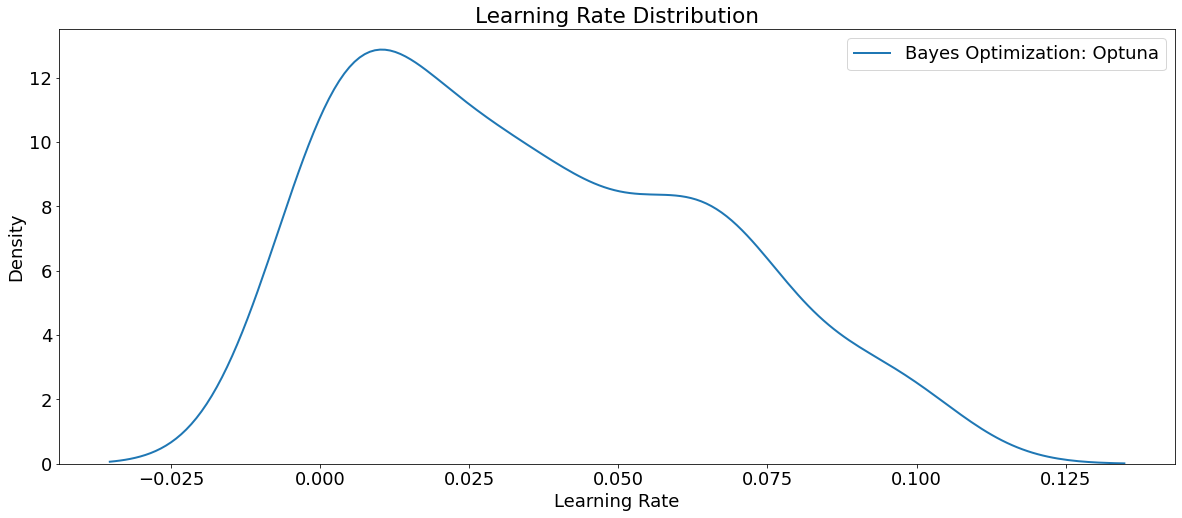

In [34]:
# Density plots of the learning rate distributions 
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
sns.kdeplot(trials_df['learning_rate'], label = 'Bayes Optimization: Optuna', 
            linewidth = 2)
plt.legend(loc = 1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

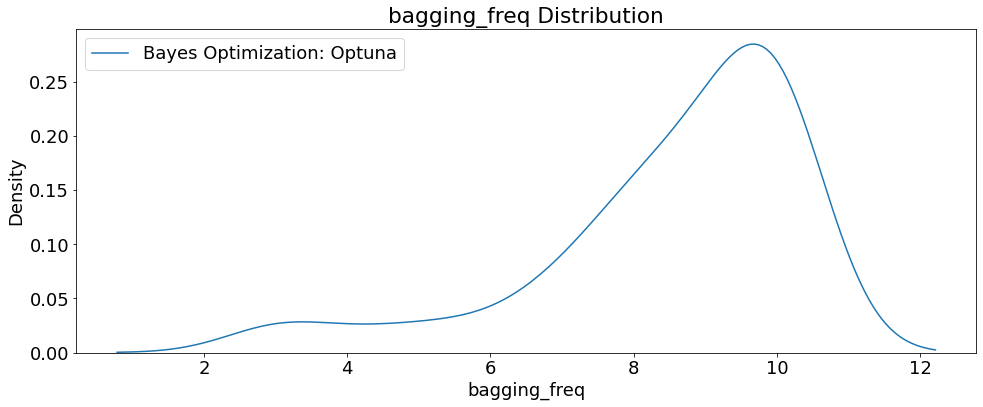

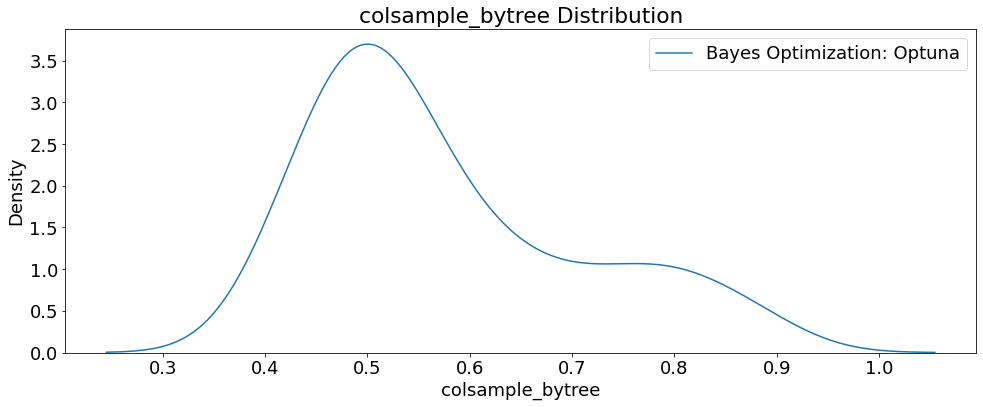

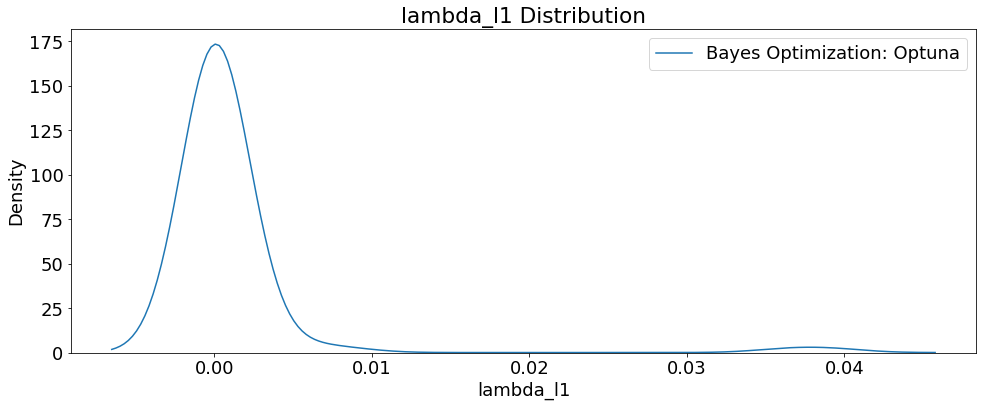

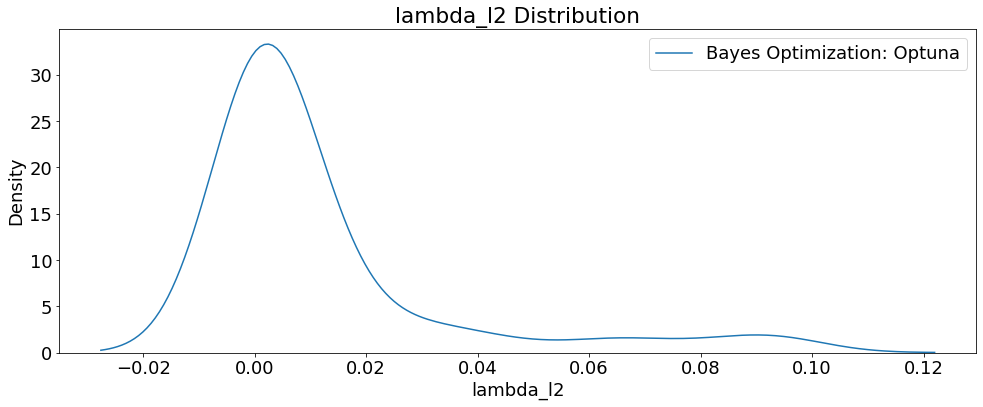

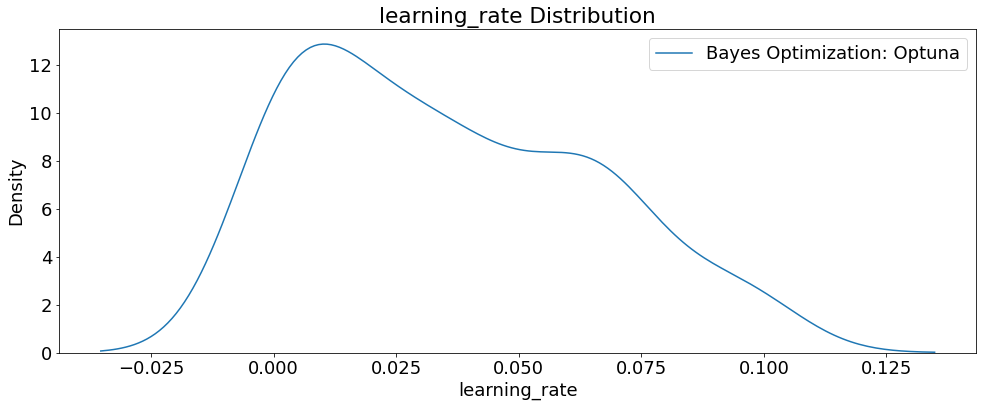

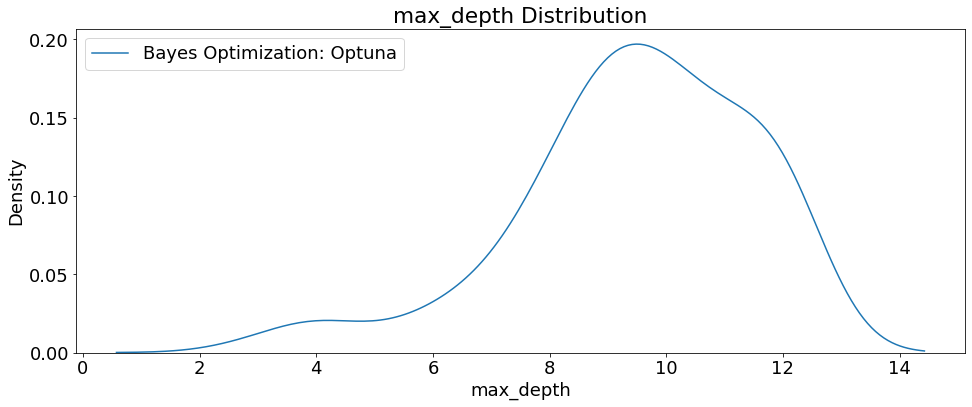

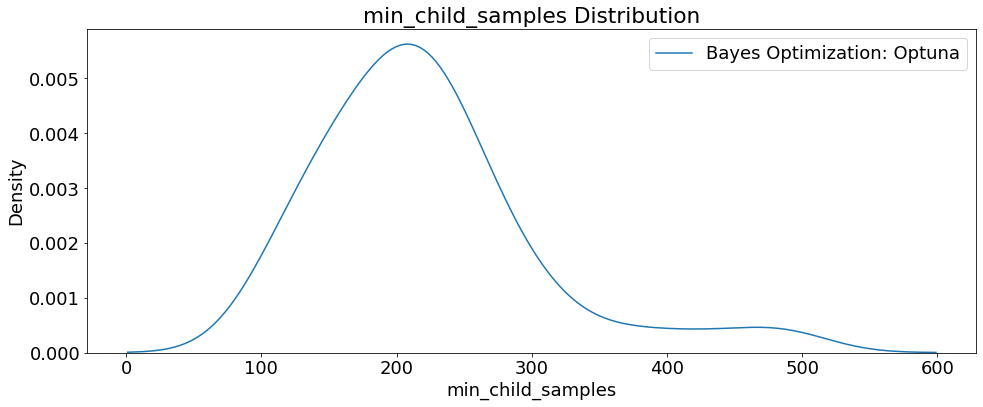

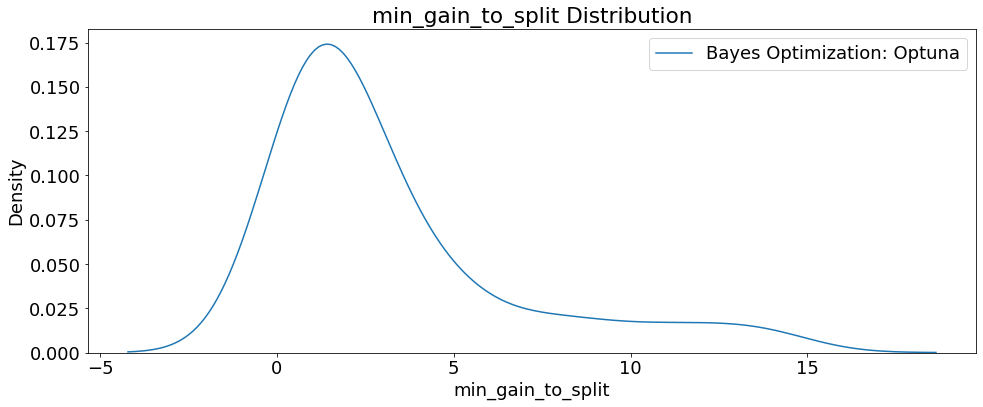

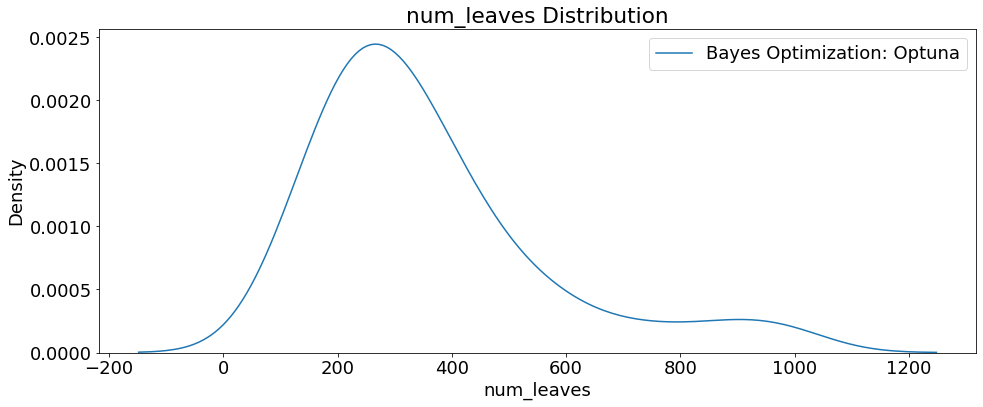

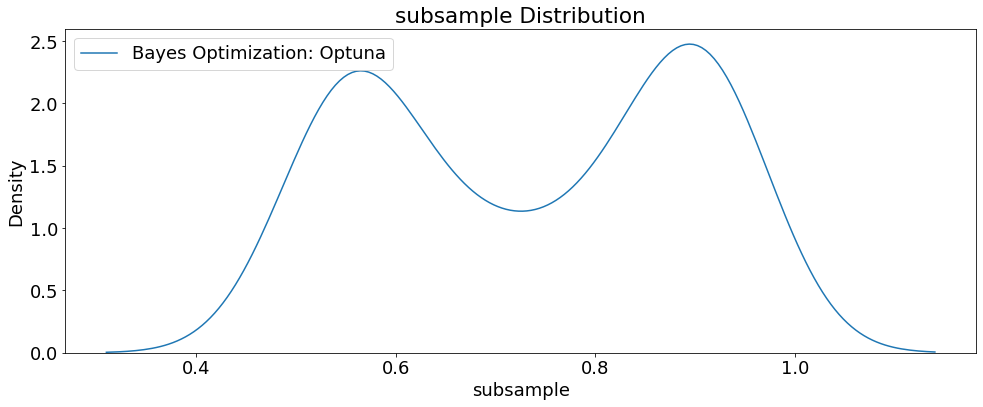

In [35]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'logloss', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning

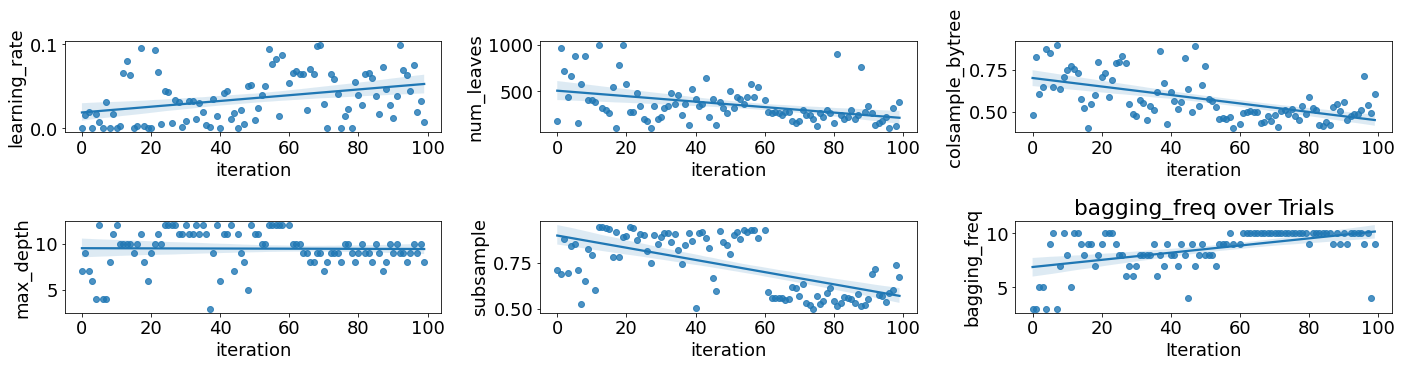

In [36]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(2, 3, figsize = (20, 5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['learning_rate', 'num_leaves', 'colsample_bytree', 
                         'max_depth', 'subsample', 'bagging_freq']): 

                        # Scatterplot
                         sns.regplot('iteration', hpo, data = trials_df, ax = axs[i]) 
axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo),  
                                    title = '{} over Trials'.format(hpo))

plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



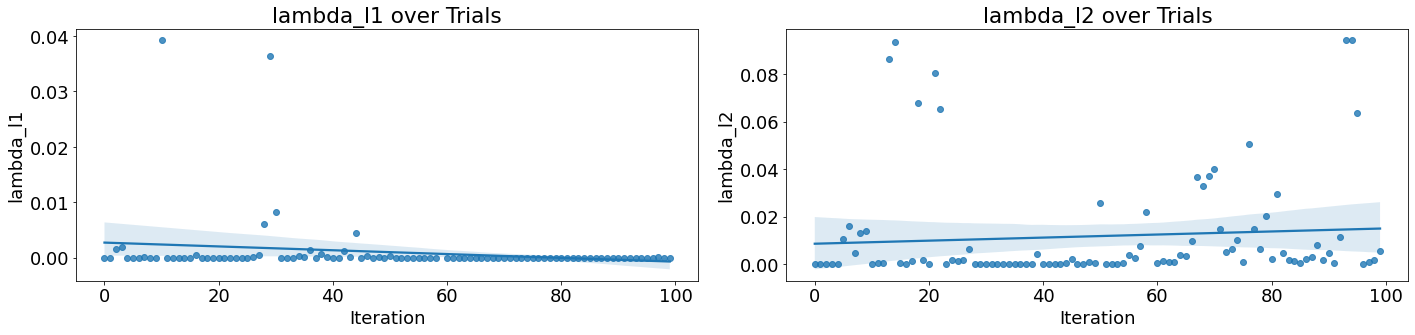

In [37]:
# Scatterplot of regularization hyperparameters)
fig, axs = plt.subplots(1, 2, figsize = (20, 5))
i = 0
for i, hpo in enumerate(['lambda_l1', 'lambda_l2']):
        # Scatterplot
        sns.regplot('iteration', hpo, data = trials_df, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo), 
                   title = '{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [38]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_lightGBM_Optuna_100_GPU_glove.html')
fig.show()

In [39]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_lightGBM_Optuna_100_GPU_glove.html')
fig.show()

In [40]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params['random_state'] = seed_value
params['metric'] = 'binary_error'
params

{'bagging_freq': 10,
 'colsample_bytree': 0.49755830308037124,
 'lambda_l1': 5.053197000578153e-06,
 'lambda_l2': 0.003921759530983894,
 'learning_rate': 0.06479189363617201,
 'max_depth': 9,
 'metric': 'binary_error',
 'min_child_samples': 210,
 'min_gain_to_split': 0.5881276349454116,
 'n_estimators': 490,
 'num_leaves': 260,
 'random_state': 42,
 'subsample': 0.5587350009428307}

In [41]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/Model_PKL/


study = joblib.load('lightGBM_Optuna_100_GPU_glove.pkl')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/Model_PKL


In [42]:
label = df[['stars_reviews']]

features = df.cleanReview

# Partition data for train/test 
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.2, stratify=label)

In [43]:
# Vectorize reviews in train/test sets
X_train = pl.fit_transform(X_train)
X_test = pl.fit_transform(X_test)

In [45]:
# Re-create the best model and train on the training data
best_model = lgb.LGBMClassifier(**params, verbosity=-1)

# Fit the model

best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'lightGBM_HPO_Optuna_trials100_GPU_glove.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('lightGBM__HPO_Optuna_trials100_GPU_glove.pkl')
# print(model)
# =============================================================================

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [46]:
print('Results from lightGBM HPO Optuna 100 GloVe GPU trials:')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report: Train')
clf_rpt = classification_report(y_train, y_train_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Train')
print(confusion_matrix(y_train, y_train_pred))
print('\n')
print('Classification Report: Test')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Test')
print(confusion_matrix(y_test, y_test_pred))
print('\n')

print('Accuracy score: train: %.3f, test: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)))
print('Precision score: train: %.3f, test: %.3f' % (
        precision_score(y_train, y_train_pred),
        precision_score(y_test, y_test_pred)))
print('Recall score: train: %.3f, test: %.3f' % (
        recall_score(y_train, y_train_pred),
        recall_score(y_test, y_test_pred)))
print('F1 score: train: %.3f, test: %.3f' % (
        f1_score(y_train, y_train_pred),
        f1_score(y_test, y_test_pred)))

Results from lightGBM HPO Optuna 100 GloVe GPU trials:


Classification Report: Train
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95    616594
         1.0       0.95      0.95      0.95    616594

    accuracy                           0.95   1233188
   macro avg       0.95      0.95      0.95   1233188
weighted avg       0.95      0.95      0.95   1233188



Confusion matrix: Train
[[586716  29878]
 [ 31503 585091]]


Classification Report: Test
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94    154149
         1.0       0.94      0.94      0.94    154149

    accuracy                           0.94    308298
   macro avg       0.94      0.94      0.94    308298
weighted avg       0.94      0.94      0.94    308298



Confusion matrix: Test
[[144969   9180]
 [  9566 144583]]


Accuracy score: train: 0.950, test: 0.939
Precision score: train: 0.951, test: 0.940
Recall score: train: 0

In [47]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/trialOptions/

# Access results
trials_df = pd.read_csv('lightGBM_Optuna_100_GPU_glove.csv')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/trialOptions


In [48]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} Accuracy on the test set.'.format(accuracy_score(y_test, y_test_pred)))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 0.93920 Accuracy on the test set.
This was achieved using these conditions:
iteration                                    64
logloss                                0.155409
datetime_start       2022-04-15 16:55:04.477148
datetime_complete    2022-04-15 16:59:19.319111
duration                 0 days 00:04:14.841963
bagging_freq                               10.0
colsample_bytree                       0.497558
lambda_l1                              0.000005
lambda_l2                              0.003922
learning_rate                          0.064792
max_depth                                   9.0
min_child_samples                         210.0
min_gain_to_split                      0.588128
n_estimators                              490.0
num_leaves                                260.0
subsample                              0.558735
state                                  COMPLETE
Name: 0, dtype: object
